# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# Import required libraries
from datetime import datetime
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

##Data Loading

In [2]:
# Load the json files for processing
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration

## Portfolio

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
items, attributes = portfolio.shape
print("Portfolio dataset has {} records and {} attributes".format(items, attributes))

Portfolio dataset has 10 records and 6 attributes


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
portfolio.describe(include='all')

,reward,channels,difficulty,duration,offer_type,id
count,10.000000,10,10.000000,10.000000,10,10
unique,NaN,4,NaN,NaN,3,10
top,NaN,"[web, email, mobile, social]",NaN,NaN,discount,2906b810c7d4411798c6938adc9daaa5
freq,NaN,4,NaN,NaN,4,1
mean,4.200000,NaN,7.700000,6.500000,NaN,NaN
std,3.583915,NaN,5.831905,2.321398,NaN,NaN
min,0.000000,NaN,0.000000,3.000000,NaN,NaN
25%,2.000000,NaN,5.000000,5.000000,NaN,NaN
50%,4.000000,NaN,8.500000,7.000000,NaN,NaN
75%,5.000000,NaN,10.000000,7.000000,NaN,NaN


Text(0.5, 1.0, 'Offer distribution per offer Type')

<Figure size 360x360 with 0 Axes>

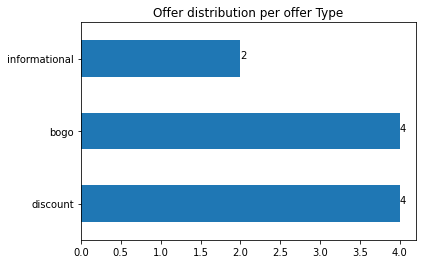

In [7]:
plt.figure(figsize=[5,5])
fig, ax = plt.subplots()    
category_count = portfolio.offer_type.value_counts()
category_count.plot(kind='barh')   
for i, count in enumerate(category_count):
  ax.text(count, i, str(count))
plt.title("Offer distribution per offer Type")

In [8]:
#Get all possible channels
import itertools
set(itertools.chain.from_iterable(portfolio.channels))

{'email', 'mobile', 'social', 'web'}

## Profile

In [9]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
items, attributes = profile.shape
print("Portfolio dataset has {} records and {} attributes".format(items, attributes))

Portfolio dataset has 17000 records and 5 attributes


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
profile.describe(include="all")

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,f3dfe66c8d74446189b21c7c704f2182,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


In [13]:
#check for null values 
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile.duplicated().sum()

0

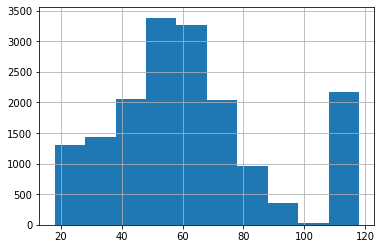

In [15]:
# age distribution
profile.age.hist();

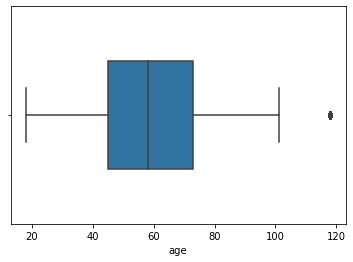

In [16]:
sns.boxplot(profile['age'], width=0.5);

Age 118 seems outlier. Lets explore it further.

In [17]:
profile[profile['age']== 118].age.count()

2175

In [18]:
profile[profile.age == 118][['gender','income']]

,gender,income
0,None,NaN
2,None,NaN
4,None,NaN
6,None,NaN
7,None,NaN
...,...,...
16980,None,NaN
16982,None,NaN
16989,None,NaN
16991,None,NaN


As per above analysis we see that wherever age is 118, the values in Gender and income is null. And also 2175 is count of such of rows. Also we saw that 2175 instances had gender and income was null. So we will drop all instances where age equals 118 as these are errorneous record.

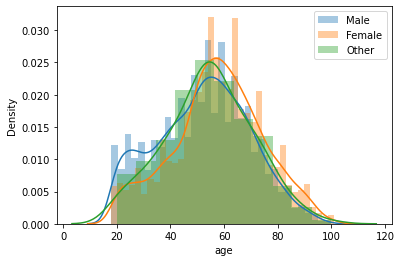

In [19]:
## Gender-wise age distribution
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
sns.distplot(profile[profile.gender=='O'].age,label='Other')
plt.legend()
plt.show()

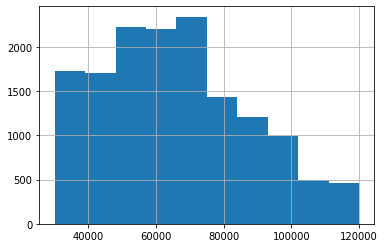

In [20]:
# distribution of income
profile.income.hist();

In [21]:
profile['income'].mean()

65404.9915682968

In [22]:
# Gender wise data distribution
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

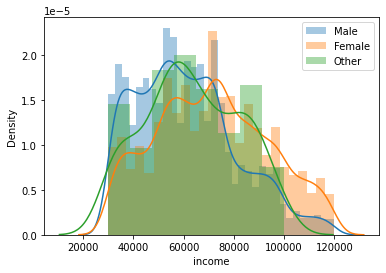

In [23]:
## Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
sns.distplot(profile[profile.gender=='O'].income,label='Other')
plt.legend()
plt.show()

## Transcript

In [24]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [25]:
items, attributes = transcript.shape
print("Transcript dataset has {} records and {} attributes".format(items, attributes))

Transcript dataset has 306534 records and 4 attributes


In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [28]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [29]:
keys = transcript['value'].apply(lambda x: list(x.keys()))
possible_keys = set()
for key in keys:
  for item in key:
    possible_keys.add(item)
print(possible_keys)

{'offer id', 'amount', 'offer_id', 'reward'}


For the **value** attribute have 3 possible value.
1. offer id/ offer_id
2. amount
3. reward

# Data cleaning & Transformation

## Portfolio

Renaming columns for better understanding and meaningfulness

In [30]:
#Rename columns
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio = portfolio.rename(columns=new_cols_name )

Exploding the channel attribute into four separate attribute - (email, mobile, social, web)

In [31]:
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, dummy], axis=1)
portfolio.drop(columns='channels', inplace=True)

In [32]:
portfolio.head()

,offer_reward,offer_difficulty,offer_duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


## Profile

Renaming columns for better understaning & meaningfulness

In [33]:
#Rename columns
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
profile = profile.rename(columns=cols_profile)

Removing rows with missing values. We saw above that all nulls belong to age 118 which are outliers.

In [34]:
#drop all rows which has null value 
profile = profile.loc[profile['gender'].isnull() == False]

Classifying ages into groups for better understanding in Exploratory Data Analysis later:
* Under 20
* 21 - 35
* 35 - 50
* 50 - 65
* Above 65

In [35]:
#Convert ages into age group
profile.loc[(profile.age <= 20) , 'Age_group'] = 'Under 20'
profile.loc[(profile.age >= 21) & (profile.age <= 35) , 'Age_group'] = '21-35'
profile.loc[(profile.age >= 36) & (profile.age <= 50) , 'Age_group'] = '36-50'
profile.loc[(profile.age >= 51) & (profile.age <= 65) , 'Age_group'] = '51-65'
profile.loc[(profile.age >= 66) , 'Age_group'] = 'Above 65'
profile.drop('age',axis=1,inplace=True)

Classifying income into income_groups for better understanding in Exploratory Data Analysis later:
* 30-50K
* 50-80K
* 80-110K
* Above 110K

In [36]:
#Convert income into income group
profile.loc[(profile.customer_income >= 30000) & (profile.customer_income <= 50000) , 'Income_group'] = '30-50K'
profile.loc[(profile.customer_income >= 50001) & (profile.customer_income <= 80000) , 'Income_group'] = '50-80K'
profile.loc[(profile.customer_income >= 80001) & (profile.customer_income <= 110000) , 'Income_group'] = '80-110K'
profile.loc[(profile.customer_income >= 110001) , 'Income_group'] = 'Above 110K'
profile.drop('customer_income',axis=1,inplace=True)

Converting became_member_on to a more quantitative term member_since_days. This will depict how long the customer has been member of the program.

In [37]:
#Convert joining date to duration in days for which the customer is member
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
baseline_date = max(profile['became_member_on'])
profile['member_since_days'] = profile['became_member_on'].apply(lambda x: (baseline_date - x).days)
profile.drop('became_member_on',axis=1,inplace=True)

In [38]:
profile.head()

,gender,customer_id,Age_group,Income_group,member_since_days
1,F,0610b486422d4921ae7d2bf64640c50b,51-65,Above 110K,376
3,F,78afa995795e4d85b5d9ceeca43f5fef,Above 65,80-110K,443
5,M,e2127556f4f64592b11af22de27a7932,Above 65,50-80K,91
8,M,389bc3fa690240e798340f5a15918d5c,51-65,50-80K,167
12,M,2eeac8d8feae4a8cad5a6af0499a211d,51-65,50-80K,257


## Transcript

Renaming columns for better understaning & meaningfulness

In [39]:
#Rename columns
transcript_cols = {'person':'customer_id'}
transcript = transcript.rename(columns=transcript_cols)

Removing space in event as when we explode, its easier to maintain columns name without space.

In [40]:
transcript['event'] = transcript['event'].str.replace(' ', '-')

Split the value column into three columns as the keys of the dictionary which represents offer_id, reward, amount. Also we will merge offer_id and "offer id" into single attribute offer_id.

In [41]:
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id'))
transcript['offer id'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['reward'] = transcript['value'].apply(lambda x: x.get('reward'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))

transcript['offer_id'] = transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
transcript.drop(['offer id' , 'value'] , axis=1, inplace=True)
transcript.fillna(0 , inplace=True)


In [42]:
transcript.head()

,customer_id,event,time,offer_id,reward,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer-received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer-received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer-received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer-received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer-received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


# Preparing data for Analysis

## Merging the three tables

In [43]:
merged_df = pd.merge(portfolio, transcript, on='offer_id')
merged_df = pd.merge(merged_df, profile, on='customer_id')

In [44]:
merged_df.head()

,offer_reward,offer_difficulty,offer_duration,offer_type,offer_id,email,mobile,social,web,customer_id,event,time,reward,amount,gender,Age_group,Income_group,member_since_days
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,offer-received,0,0.0,0.0,M,51-65,80-110K,320
1,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,offer-viewed,102,0.0,0.0,M,51-65,80-110K,320
2,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,offer-received,504,0.0,0.0,M,51-65,80-110K,320
3,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,offer-viewed,510,0.0,0.0,M,51-65,80-110K,320
4,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,offer-completed,510,10.0,0.0,M,51-65,80-110K,320


In [45]:
merged_df.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer-completed  bogo             15258
                 discount         17186
offer-received   bogo             26537
                 discount         26664
                 informational    13300
offer-viewed     bogo             22039
                 discount         18461
                 informational     9360
Name: offer_type, dtype: int64

In [46]:
merged_df['event'] = merged_df['event'].map({'offer-received':1, 'offer-viewed':2, 'offer-completed':3})

## Generating the target variable

When a customer completes the offer against an offer_id we will label that as a success. If the status is not in Offer-completed then the cust_id, order_id detail we be considerd as unsuccessful ad targeting.

In [47]:
#Create a target variable from event
merged_df['Offer_Encashed'] = 0
for row in range(merged_df.shape[0]):
    current_event = merged_df.at[row,'event']
    if current_event == 3:
        merged_df.at[row,'Offer_Encashed'] = 1

In [48]:
merged_df.Offer_Encashed.value_counts()

0    116361
1     32444
Name: Offer_Encashed, dtype: int64

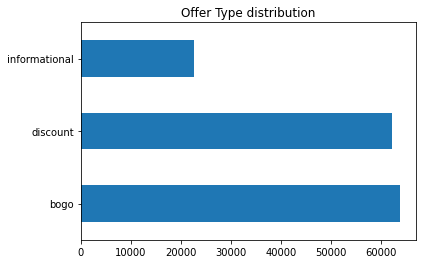

In [49]:
merged_df['offer_type'].value_counts().plot.barh(title='Offer Type distribution')

Buy One Get One & discount Offer type have similar distribution.

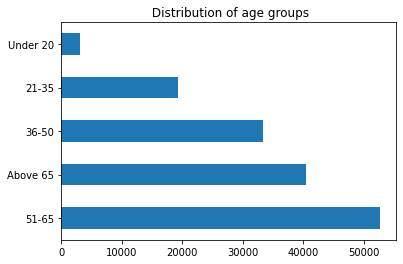

In [50]:
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of age groups')

It is quite surprising to see that customers Above 60 use Starbucks application the most, those with age 40-60 are on the second. One would usually think that customers between age 20-45 use app the most, but this is not the case here.

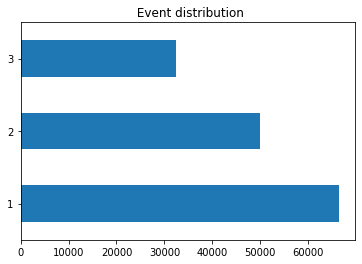

In [51]:
merged_df['event'].value_counts().plot.barh(title=' Event distribution')

From distribution it follows the sales funnel. 
Offer received > Offer Viewed > Offer completed.

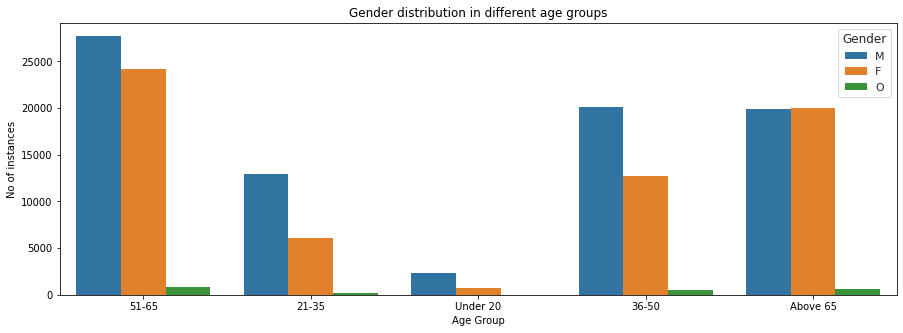

In [52]:
plt.figure(figsize=(15, 5))
sns.countplot(x="Age_group", hue="gender", data=merged_df)
sns.set(style="whitegrid")
plt.title('Gender distribution in different age groups')
plt.ylabel('No of instances')
plt.xlabel('Age Group')
plt.legend(title='Gender')

The male customers are more than the female ones in each age group. Buut in above 60 range the distribution is almost 50-50

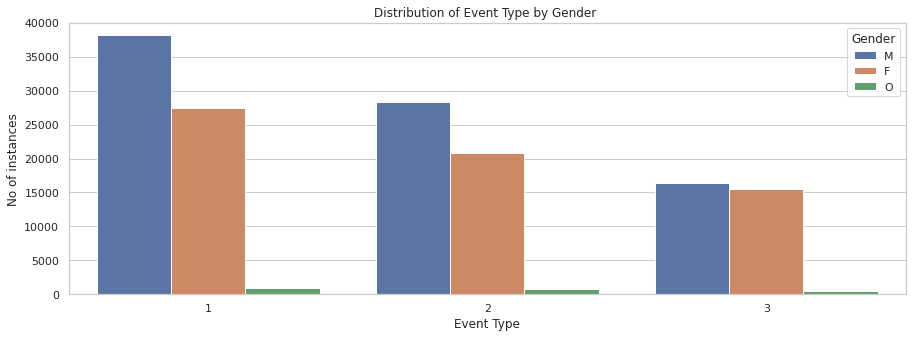

In [53]:
plt.figure(figsize=(15, 5))
sns.countplot(x="event", hue="gender", data=merged_df)
plt.title('Distribution of Event Type by Gender ')
plt.ylabel('No of instances')
plt.xlabel('Event Type')
plt.legend(title='Gender')

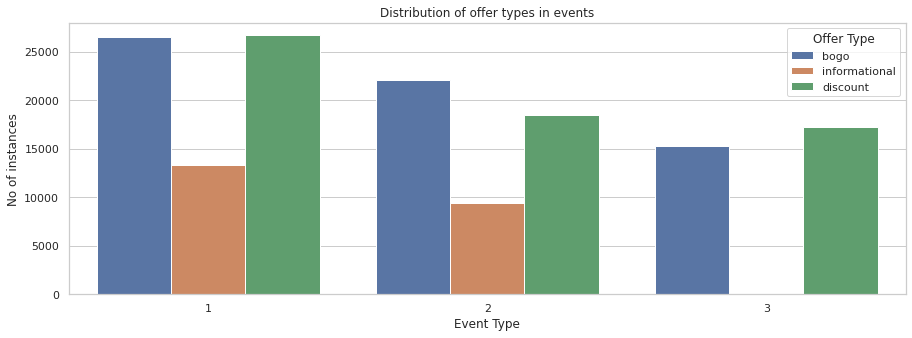

In [54]:
plt.figure(figsize=(15, 5))
sns.countplot(x="event", hue="offer_type", data=merged_df)
plt.title('Distribution of offer types in events')
plt.ylabel('No of instances')
plt.xlabel('Event Type')
plt.legend(title='Offer Type')

From the graph we can infer that the discount offer type once viewed are very likely to be completed. 

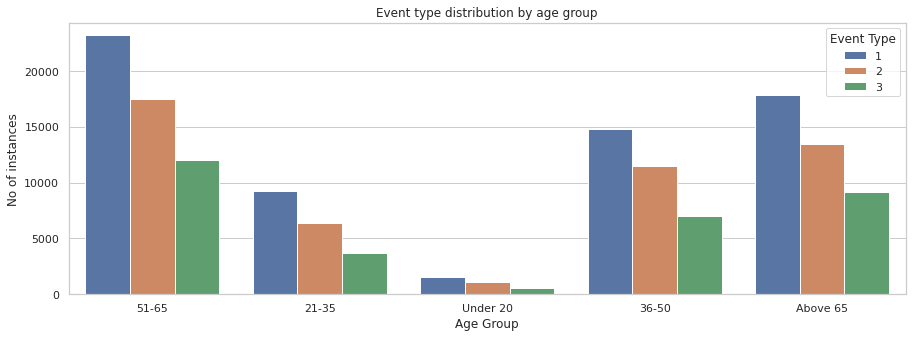

In [55]:
plt.figure(figsize=(15, 5))
sns.countplot(x="Age_group", hue="event", data=merged_df)
plt.title('Event type distribution by age group')
plt.ylabel('No of instances')
plt.xlabel('Age Group')
plt.legend(title='Event Type')

# iv) Build a Machine Learning model to predict response of a customer to an offer

## 1. Data Preparation and Cleaning II

#### Tasks
1. Encode categorical data such as gender, offer type and age groups.
2. Encode the 'event' data to numerical values:
    * offer received ---> 1
    * offer viewed ---> 2
    * offer completed ---> 3
3. Encode offer id.
4. Scale and normalize numerical data.

In [56]:
dummy = pd.get_dummies(merged_df.offer_type.apply(pd.Series).stack()).sum(level=0)
merged_df = pd.concat([merged_df, dummy], axis=1)
merged_df.drop(columns='offer_type', inplace=True)

In [57]:
dummy = pd.get_dummies(merged_df.gender.apply(pd.Series).stack()).sum(level=0)
merged_df = pd.concat([merged_df, dummy], axis=1)
merged_df.drop(columns='gender', inplace=True)

In [58]:
dummy = pd.get_dummies(merged_df.Age_group.apply(pd.Series).stack()).sum(level=0)
merged_df = pd.concat([merged_df, dummy], axis=1)
merged_df.drop(columns='Age_group', inplace=True)

In [59]:
dummy = pd.get_dummies(merged_df.Income_group.apply(pd.Series).stack()).sum(level=0)
merged_df = pd.concat([merged_df, dummy], axis=1)
merged_df.drop(columns='Income_group', inplace=True)

In [60]:
offerids = merged_df['offer_id'].unique().tolist()
o_mapping = dict( zip(offerids,range(len(offerids))) )
merged_df.replace({'offer_id': o_mapping},inplace=True)

Distribution of encashemnt of offer by Age group and gender.

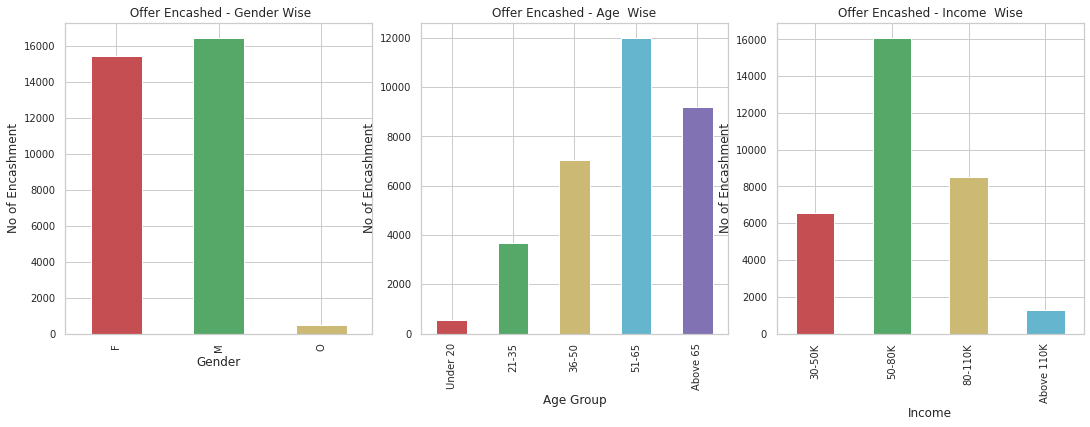

In [61]:
sns.set_style('whitegrid')
bar_color= ['r', 'g', 'y', 'c', 'm']
fig,ax= plt.subplots(1,3,figsize=(15,5))
fig.tight_layout()

merged_df[merged_df['Offer_Encashed']==1][['F','M','O']].sum().plot.bar(ax=ax[0], fontsize=10,color=bar_color) 
ax[0].set_title(" Offer Encashed - Gender Wise")
ax[0].set_xlabel("Gender")
ax[0].set_ylabel("No of Encashment")

age_cols=['Under 20','21-35', '36-50', '51-65', 'Above 65']
merged_df[merged_df['Offer_Encashed']==1][age_cols].sum().plot.bar(ax=ax[1], fontsize=10,color=bar_color) 
ax[1].set_title("Offer Encashed - Age  Wise")
ax[1].set_xlabel("Age Group")
ax[1].set_ylabel("No of Encashment")

income_cols=['30-50K', '50-80K', '80-110K', 'Above 110K']
merged_df[merged_df['Offer_Encashed']==1][income_cols].sum().plot.bar(ax=ax[2], fontsize=10, color=bar_color) 
ax[2].set_title("Offer Encashed - Income  Wise")
ax[2].set_xlabel("Income")
ax[2].set_ylabel("No of Encashment")
plt.show()

In [62]:
#drop customer_id,  time, amount, event
merged_df.drop(['customer_id', 'time', 'amount', 'event', 'reward'], axis=1, inplace=True)

In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical = ['offer_difficulty', 'offer_duration', 'offer_reward', 'member_since_days']
merged_df[numerical] = scaler.fit_transform(merged_df[numerical])

In [64]:
merged_df.drop_duplicates(inplace=True)

In [65]:
merged_df.head()

,offer_reward,offer_difficulty,offer_duration,offer_id,email,mobile,social,web,member_since_days,Offer_Encashed,bogo,discount,informational,F,M,O,21-35,36-50,51-65,Above 65,Under 20,30-50K,50-80K,80-110K,Above 110K
0,1.0,0.5,0.571429,0,1,1,1,0,0.175535,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
4,1.0,0.5,0.571429,0,1,1,1,0,0.175535,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
5,0.0,0.0,0.142857,1,1,1,0,1,0.175535,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
7,0.5,1.0,1.000000,2,1,0,0,1,0.175535,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
9,0.5,1.0,1.000000,2,1,0,0,1,0.175535,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0


## 2. Split train and test data

Final data is ready after tasks 1-5. We will now split the data (both features and their labels) into training and test sets, taking 60% of data for training and 40% for testing.

In [66]:
data = merged_df.drop('Offer_Encashed', axis=1)
label = merged_df['Offer_Encashed']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state = 4756)
print("Train: {} Test {}".format(X_train.shape[0], X_test.shape[0]))

Train: 52300 Test 22415


## Model training and testing

### Metrics

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [68]:
def get_model_scores(classifier):
    train_prediction =  (classifier.fit(X_train, y_train)).predict(X_train)
    test_predictions = (classifier.fit(X_train, y_train)).predict(X_test)
    f1_train =  accuracy_score(y_train, train_prediction)*100
    f1_test = fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    clf_name = classifier.__class__.__name__
    
    return f1_train, f1_test, clf_name

### LogisticRegression (Benchmark)

I am using LogisticRegression classifier to build the benchmark, and evaluate the model result by the F1 score metric.

In [69]:
lr_clf = LogisticRegression(random_state = 10)
lr_f1_train, lr_f1_test, lr_model = get_model_scores(lr_clf)

In [70]:
linear = {'Benchmark Model': [ lr_model], 'F1-Score(Training)':[lr_f1_train], 'F1-Score(Test)': [lr_f1_test]}
benchmark = pd.DataFrame(linear)

In [71]:
benchmark

,Benchmark Model,F1-Score(Training),F1-Score(Test)
0,LogisticRegression,64.90631,65.353558


### RandomForestClassifier

In [72]:
rf_clf = RandomForestClassifier(random_state = 10, criterion='gini', min_samples_leaf=10, min_samples_split=2, n_estimators=100)
rf_f1_train, rf_f1_test, rf_model = get_model_scores(rf_clf)

### DecisionTreeClassifier

In [73]:
dt_clf = DecisionTreeClassifier(random_state = 10)
dt_f1_train, dt_f1_test, dt_model = get_model_scores(dt_clf)

### K Nearest Neighbors

In [74]:
knn_clf = KNeighborsClassifier(n_neighbors = 5)
knn_f1_train, knn_f1_test, knn_model = get_model_scores(knn_clf)

## Classifier Evaluation Summary

In [75]:
performance_summary = {'Classifier': [lr_model, rf_model, dt_model, knn_model], 
          'F1-Score':[lr_f1_train, rf_f1_train, dt_f1_train, knn_f1_train] }
          
performance_summary = pd.DataFrame(performance_summary)

In [76]:
performance_summary

,Classifier,F1-Score
0,LogisticRegression,64.906310
1,RandomForestClassifier,67.497132
2,DecisionTreeClassifier,75.458891
3,KNeighborsClassifier,69.451243
